# 8200Bio Data Challenge
In this challenge the goal was to predict the medical specialty from the transcription field,
that is for each file (unique transcription) need to predict whether it belongs to each label (medical specialty).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from joblib import dump, load
from sklearn.metrics import f1_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

stop_words = set(stopwords.words('english'))

In [2]:
df = pd.read_csv('Data/data.csv')

df.sample(5)

,transcription,specialty
2508,"PREOPERATIVE DIAGNOSIS: ,Oropharyngeal foreig...",Surgery
2988,"PROCEDURE PERFORMED: , Port-A-Cath insertion.,...",Surgery
1091,"CC:, Episodic mental status change and RUE num...",Neurology
3618,"PREOPERATIVE DIAGNOSES: , Vault prolapse and r...",Surgery
1548,"SCLERAL BUCKLE OPENING,The patient was brought...",Ophthalmology


## Work strategy:
<br/>

* __Text2Vec:__ Convert text to vector of strings not including classification and words meaningless in term of classification.
<br/><br/>
* __StringVec2FloatVec:__ Convert Vector Numbers The vector numbers are used using one of the common conversion methods.<br/><br/>
* __Dealing with unbalanced data:__ The data is not balanced! We will duplicate the underrepresented data so that the classification is balanced.<br/><br/>
* __Train & Test models:__ Training different classic models for best results.<br/><br/>

# Text2Vec

In [3]:
#Level 1: Convert the text into a set of words as simply as possible

df['transcription'] = df['transcription'].apply(lambda x: nltk.word_tokenize(x))

In [4]:
# I decided not to delete the negative words because sometimes they change the meaning of the text drastically

stop_words = list(stop_words) + [',',':','.',';','',' ',"'","'s"]
stop_words = list(filter(lambda x: "n't" not in x and x != 'not', stop_words))

In [5]:
#Level 2: Drop the meaningless words from the array

df['transcription'] = df['transcription'].apply(lambda x: list(filter(lambda word: word.lower() not in stop_words, x)))

In [6]:
#Level 3: Clean marks and etc. to maintain uniformity

def clean_array(array):
    array = list(map(lambda x: x.replace(".",""), array))
    array = list(map(lambda x: x.replace("'",""), array))
    array = list(map(lambda x: x.replace("`",""), array))
    array = list(map(lambda x: x.replace("-"," "), array))
    array = list(map(lambda x: x.strip(), array))
    array = list(map(lambda x: x.lower(), array))
    return array

df['transcription'] = df['transcription'].apply(lambda x: clean_array(x))

In [7]:
df

,transcription,specialty
0,"[admitting, diagnosis, kawasaki, disease, disc...",Allergy / Immunology
1,"[chief, complaint, 5 year old, male, presents,...",Allergy / Immunology
2,"[history, 34 year old, male, presents, today, ...",Allergy / Immunology
3,"[history, pleasure, meeting, evaluating, patie...",Allergy / Immunology
4,"[subjective, 42 year old, white, female, comes...",Allergy / Immunology
...,...,...
3687,"[preoperative, diagnoses, ,1, urinary, retenti...",Urology
3688,"[preoperative, diagnosis, clinical, stage, ta,...",Urology
3689,"[preoperative, diagnosis, bilateral, vesicoure...",Urology
3690,"[preoperative, diagnosis, inguinal, hernia, po...",Urology


# StringVec2FloatVec (By df-idf score)
We will try to transfer the data to numbers using two conversion versions: <br/> <br/>
__1)__ By frequency. <br/><br/>
__2)__ TF-IDF Score: <br/>
<img src="https://miro.medium.com/max/1200/1*V9ac4hLVyms79jl65Ym_Bw.jpeg" alt="drawing" width="450"/><br/>


In [8]:
'''
The first method was rejected because the second result brought better results than it.

Hypothesis why this happened: In binary data the classification is "sharper" and gives equal weight to each word,
so overfitting can be created.
'''


#transcriptions = list(df['transcription'])
#transcriptions = list(map(lambda x: ' '.join(x),transcriptions))

#vectorizer = CountVectorizer()
#X = vectorizer.fit_transform(transcriptions)

#X = X.toarray()

#features_df = pd.DataFrame(X)

'\nThe first method was rejected because the second result brought better results than it.\n\nHypothesis why this happened: In binary data the classification is "sharper" and gives equal weight to each word,\nso overfitting can be created.\n'

In [9]:
transcriptions = list(df['transcription'])
transcriptions = list(map(lambda x: ' '.join(x),transcriptions))

vec = TfidfVectorizer()
X = vec.fit_transform(transcriptions)

X = X.toarray()

In [10]:
features_df = pd.DataFrame(X)

features_df

,0,1,2,3,4,5,6,7,8,9,...,21439,21440,21441,21442,21443,21444,21445,21446,21447,21448
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3687,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3688,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3689,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3690,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Add binary label column
Since this is a multiple classification problem we are going to train 33 different models (as the number of possible outcomes) as binary classifieds, so for convenience it is better to add 33 columns with binary representations in relation to each specialty.

In [11]:
def is_specialty(x,specialty):
    if x == specialty:
        return 1
    return 0

In [12]:
#I decided to add this value because there were too many rows of zeros 
#and I wanted to give every feature a weight (this increased the models' score) - like a bias
features_df += 0.00001

features_df['specialty'] = df['specialty']

for specialty in features_df['specialty'].unique():
    features_df[specialty] = features_df['specialty'].apply(lambda x: is_specialty(x, specialty))
    
features_df

,0,1,2,3,4,5,6,7,8,9,...,Pediatrics - Neonatal,Physical Medicine - Rehab,Podiatry,Psychiatry / Psychology,Radiology,Rheumatology,Sleep Medicine,Surgery,Urology,speciality
0,0.00001,0.00001,0.000010,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,...,0,0,0,0,0,0,0,0,0,0
1,0.00001,0.00001,0.000010,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,...,0,0,0,0,0,0,0,0,0,0
2,0.00001,0.00001,0.000010,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,...,0,0,0,0,0,0,0,0,0,0
3,0.00001,0.00001,0.000010,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,...,0,0,0,0,0,0,0,0,0,0
4,0.00001,0.00001,0.000010,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3687,0.00001,0.00001,0.000010,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,...,0,0,0,0,0,0,0,0,1,0
3688,0.00001,0.00001,0.000010,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,...,0,0,0,0,0,0,0,0,1,0
3689,0.00001,0.00001,0.000010,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,...,0,0,0,0,0,0,0,0,1,0
3690,0.00001,0.00001,0.000010,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,...,0,0,0,0,0,0,0,0,1,0


## Dealing with unbalanced data

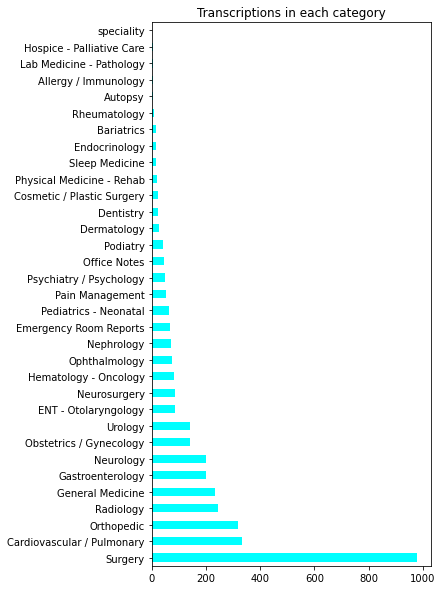

In [13]:
features_df.specialty.value_counts().plot(color = 'cyan',kind='barh',figsize=(5, 10), title='Transcriptions in each category' )
plt.show()

In [14]:
'''
I tried to do smote but this method did not work well in training & testing.
Hypothesis: The model has a lot of features and it is possible that the differences 
in some dimensions are very small between the data and therefore it is difficult generate new data.
'''

#smote = SMOTE()

'\nI tried to do smote but this method did not work well in training & testing.\nHypothesis: The model has a lot of features and it is possible that the differences \nin some dimensions are very small between the data and therefore it is difficult generate new data.\n'

In [15]:
for specialty in tqdm(df.specialty.value_counts().keys()):
    num = int(979 / len(features_df[features_df['specialty'] == specialty].index)) - 1
    df1 = features_df[features_df['specialty'] == specialty] 
    features_df = pd.concat([features_df] + [df1]*num)

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:34<00:00,  1.04s/it]


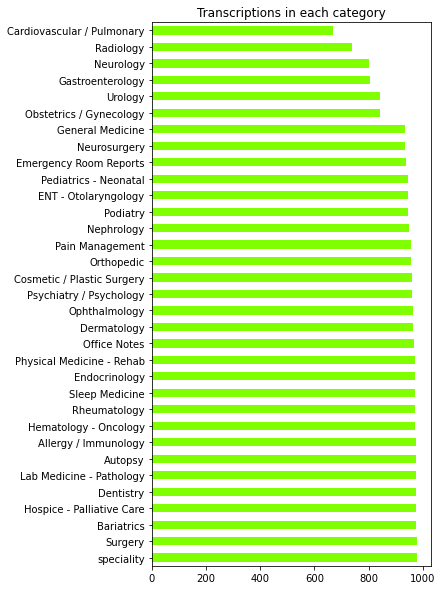

In [16]:
features_df.specialty.value_counts().plot(color = 'chartreuse',kind='barh',figsize=(5, 10), title='Transcriptions in each category' )
plt.show()

In [17]:
features_df = features_df.drop(['specialty'], axis=1) 

## Train & Test models
Now that the data is ready, all that remains is to train it - we will train it on 9 different models for each specialty and we will choose the best one.

In [18]:
def TestDetails(model,x_train, x_test, y_train, y_test):
    
    ret = {}
    ret["Model"] = model
    ret["Train Score"] = model.score(x_train, y_train)
    ret["Test Score"] = model.score(x_test, y_test)
    
    return ret

In [19]:
def Test(df,specialty):
    
    results = {}
    
    size = df[df[specialty] == 1].count()[0]
    newdf = pd.concat([df[df[specialty] == 1] , df[df[specialty] != 1].sample(size)])
    newdf = newdf.sample(frac=1)
    X ,y = newdf.iloc[:,0:21449], newdf.iloc[:,21449:][specialty]
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    
    
    #1. Naive Bayes
    
    #'''
    mnb = MultinomialNB().fit(x_train, y_train)
    
    results["Naive Bayes"] = TestDetails(mnb,x_train, x_test, y_train, y_test)
    #'''
    
    #2. Logistic Regression
    
    #'''
    lr = LogisticRegression(max_iter=2000).fit(x_train, y_train)
    
    results["Logistic Regression"] = TestDetails(lr,x_train, x_test, y_train, y_test)
    #'''
    
    #3. K-Nearest Neighbours
    
    #'''
    knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1).fit(x_train, y_train)
    
    results["KNearest Neighbours"] = TestDetails(knn,x_train, x_test, y_train, y_test)
    #'''
    
    #4. Support Vector Machine
    
    #'''
    svm = LinearSVC(C=0.0001).fit(x_train, y_train)
    
    results["Support Vector Machine"] = TestDetails(svm,x_train, x_test, y_train, y_test)
    #'''

    #5. Decision Tree
    
    #'''
    clf = DecisionTreeClassifier().fit(x_train, y_train)
    
    results["Decision Tree"] = TestDetails(clf,x_train, x_test, y_train, y_test)
    #'''
    
    #6. Bagging Decision Tree
    
    #'''
    bg=BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10).fit(x_train, y_train)
    
    results["Bagging Decision Tree"] = TestDetails(bg,x_train, x_test, y_train, y_test)
    #'''
    
    #7. Boosting Decision Tree
    
    #'''
    adb = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=4),n_estimators=10,learning_rate=0.6).fit(x_train, y_train)
    
    results["Boosting Decision Tree"] = TestDetails(adb,x_train, x_test, y_train, y_test)
    #'''
    
    #8. Random Forest 
    
    #'''
    rf = RandomForestClassifier( max_depth=7, random_state=6).fit(x_train, y_train)
    
    results["Random Forest"] = TestDetails(rf,x_train, x_test, y_train, y_test)
    #'''
    
    #9. Voting Classifier
    
    #'''
    evc = VotingClassifier(estimators=[('mnb',mnb),('lr',lr),('rf',rf),('svm',svm)],voting='hard').fit(x_train, y_train)
    
    results["Voting Classifier"] = TestDetails(rf,x_train, x_test, y_train, y_test)
    #'''
    
    return results
   

In [20]:
def plot_accuracy(result,specialty):

    Train_Score = list(map(lambda x: x['Train Score'],list(result.values())))
    Test_Score = list(map(lambda x: x['Test Score'],list(result.values())))
    Models = list(result.keys())
    
    x = np.arange(len(Models))
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, Train_Score, width, label='Train')
    rects2 = ax.bar(x + width/2, Test_Score, width, label='Test')

    plt.grid()

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Accuracy')
    ax.set_title(specialty + ' Accuracy by Model')
    ax.set_xticks(x)
    ax.set_xticklabels(Models, rotation=20)
    ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    ax.legend()

    fig.set_size_inches(13, 5, forward=True)

    fig.tight_layout()

    plt.show()

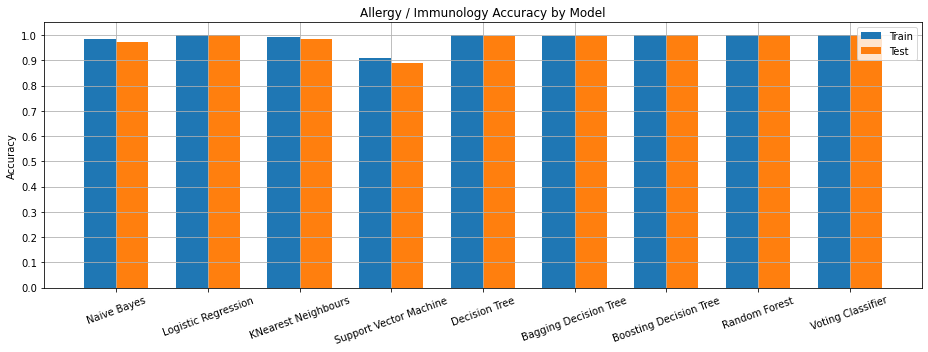

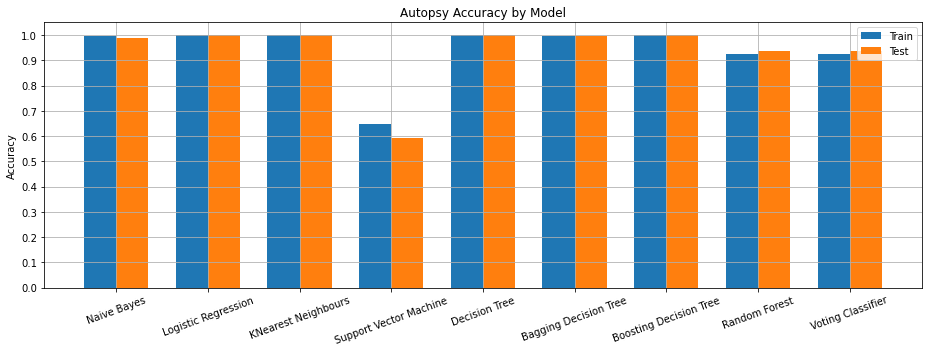

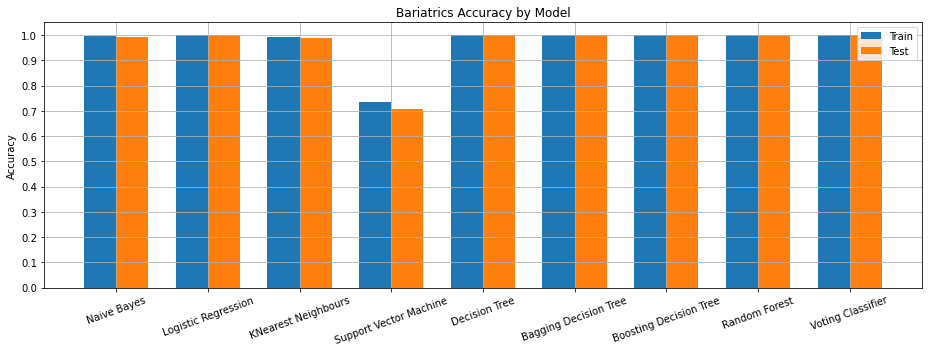

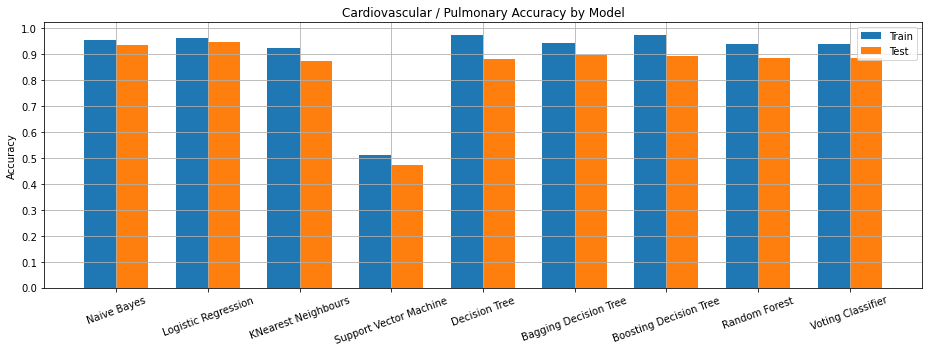

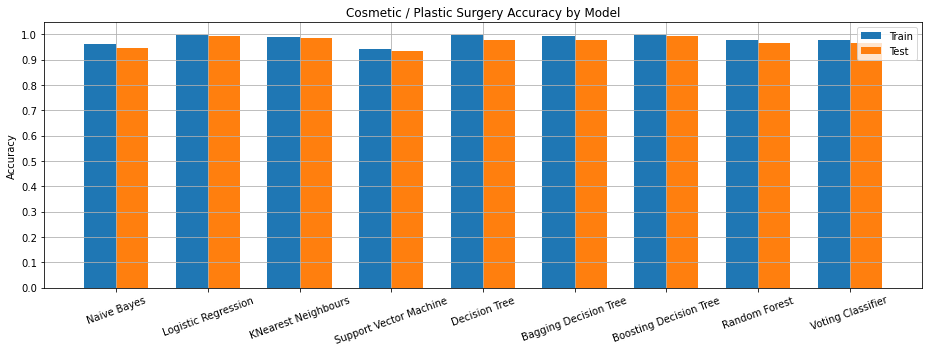

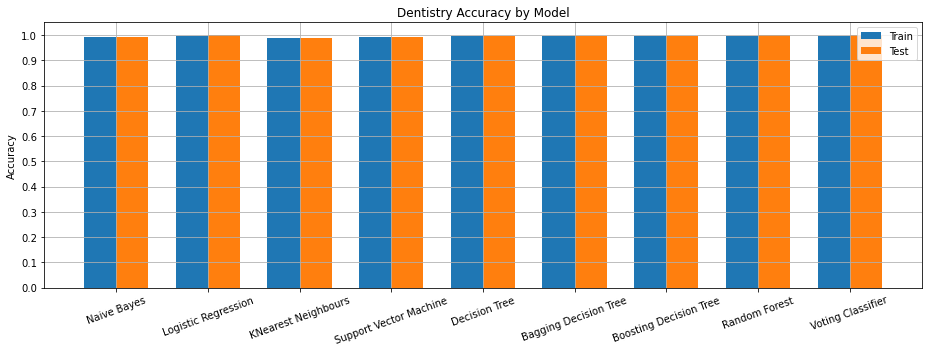

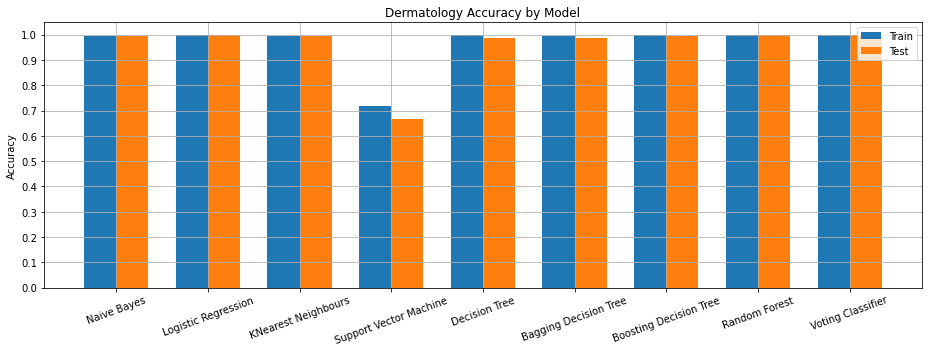

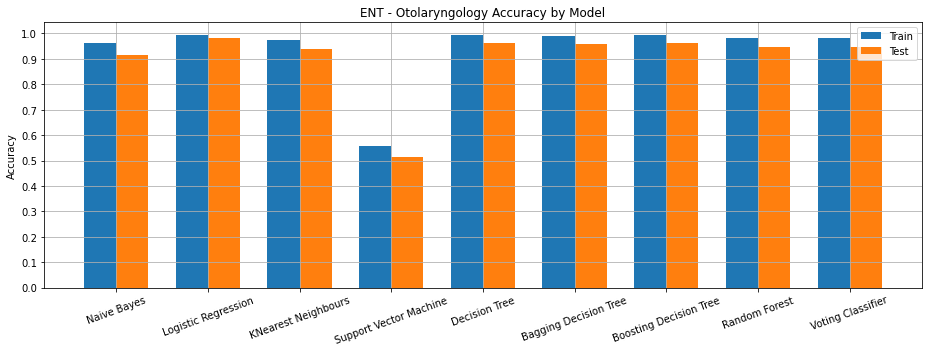

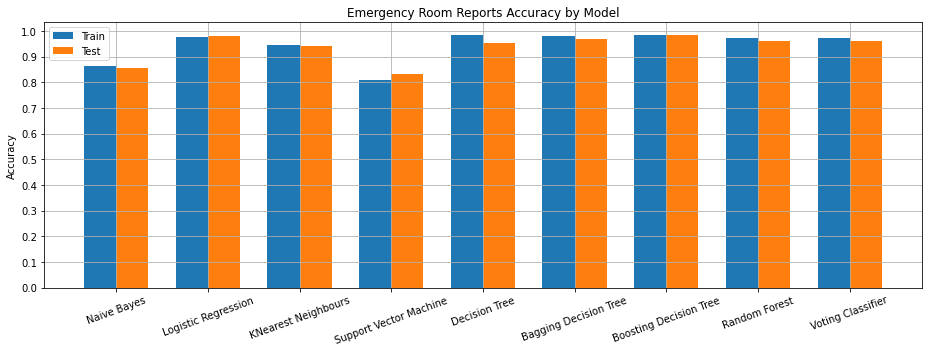

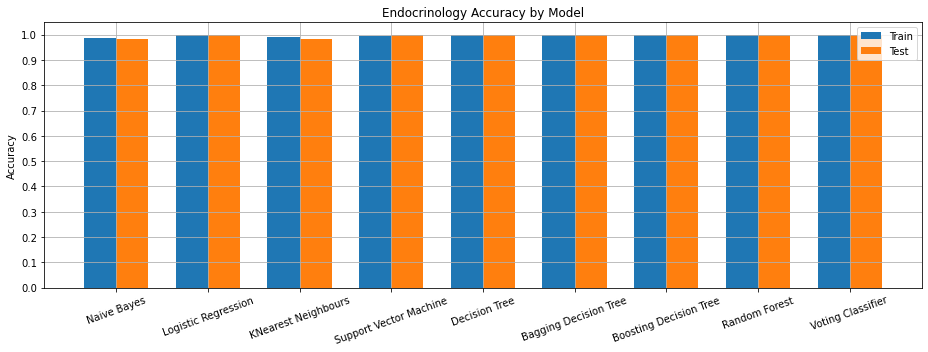

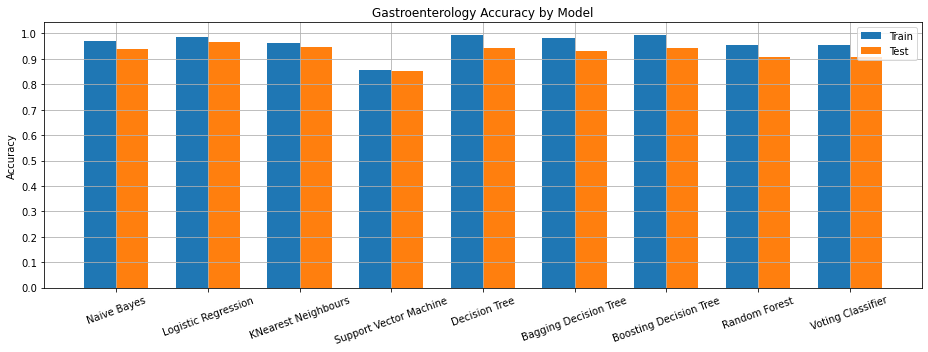

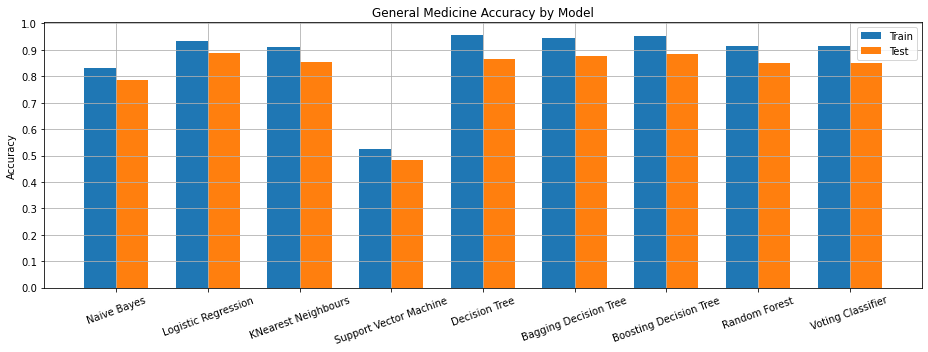

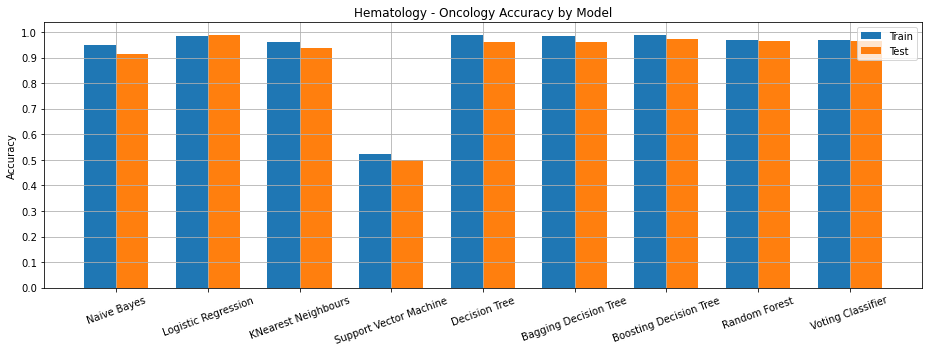

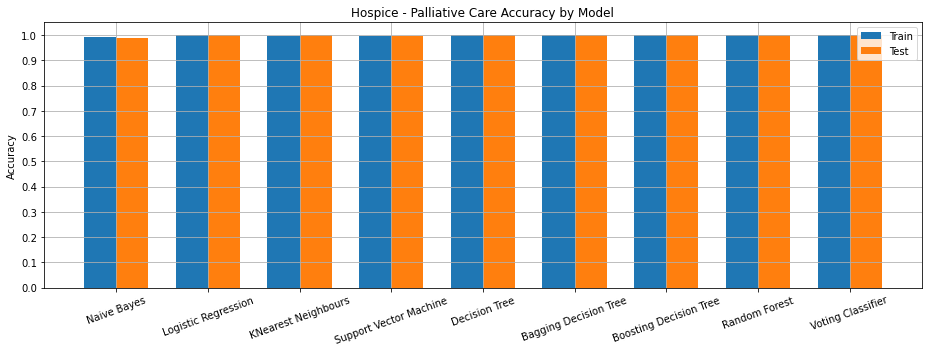

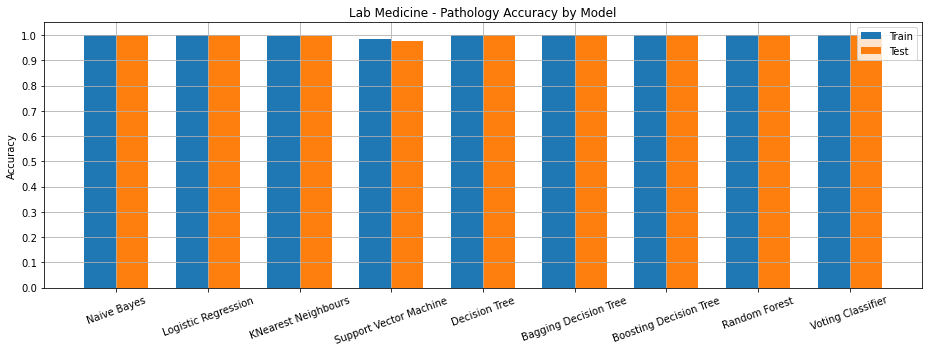

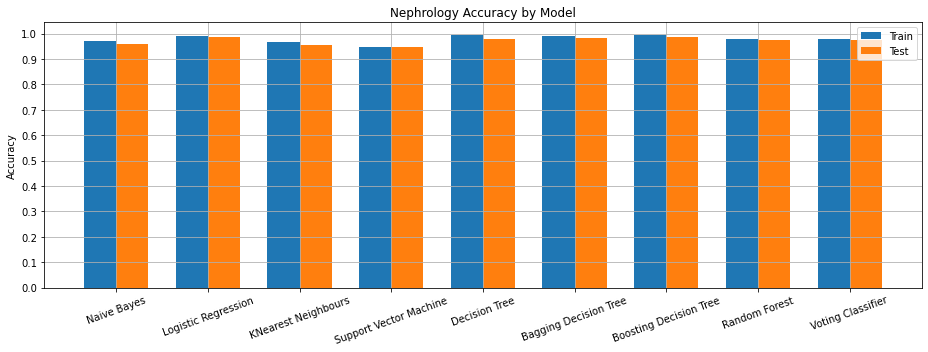

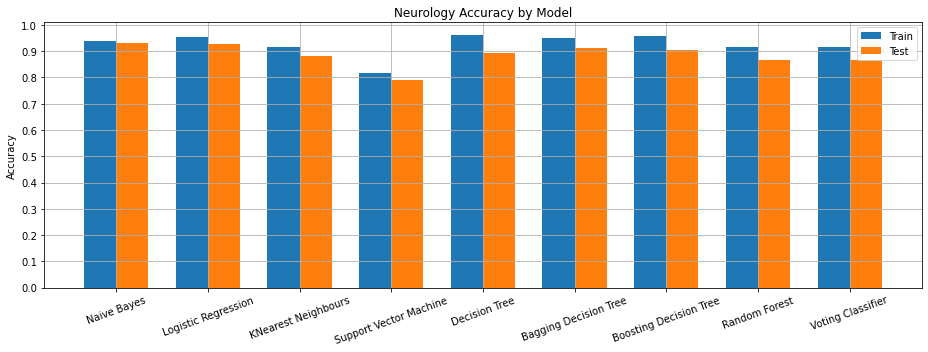

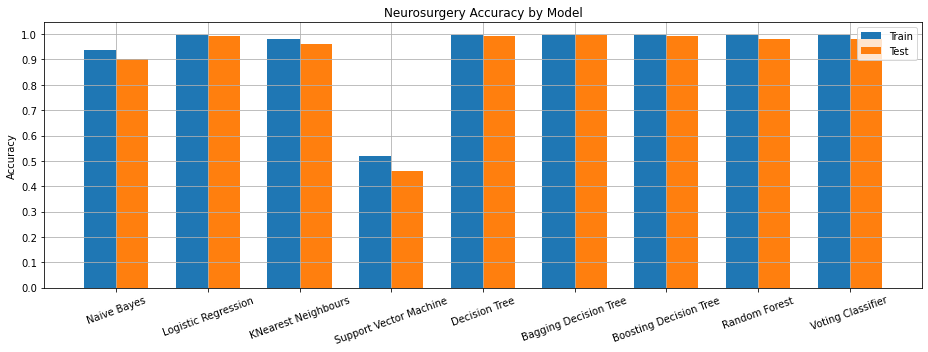

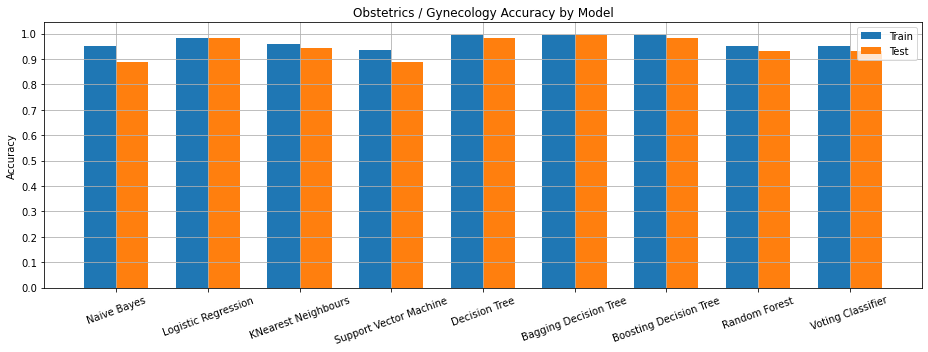

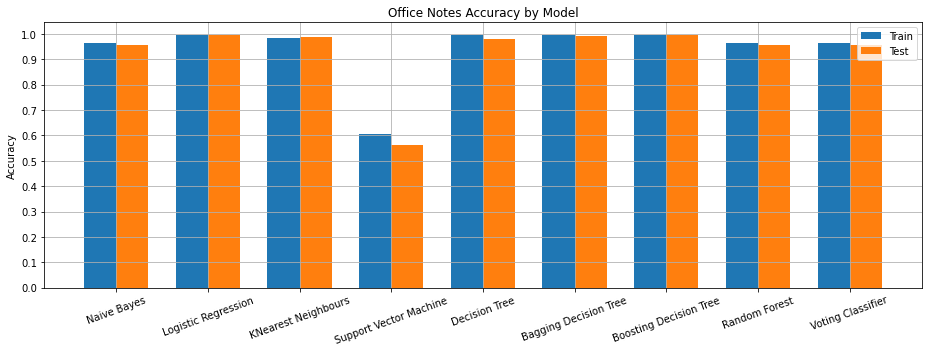

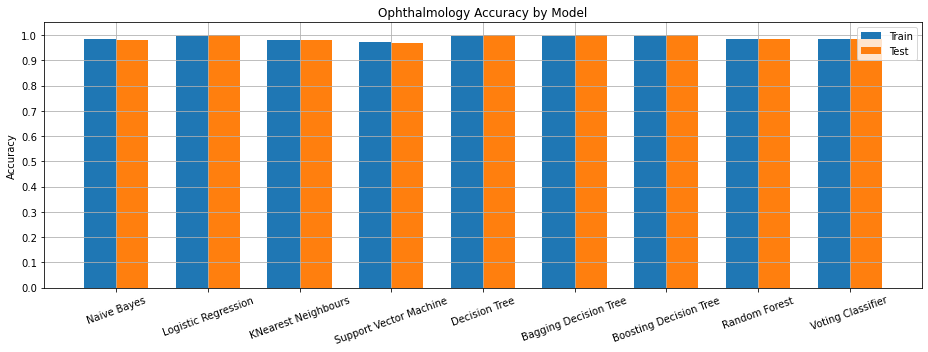

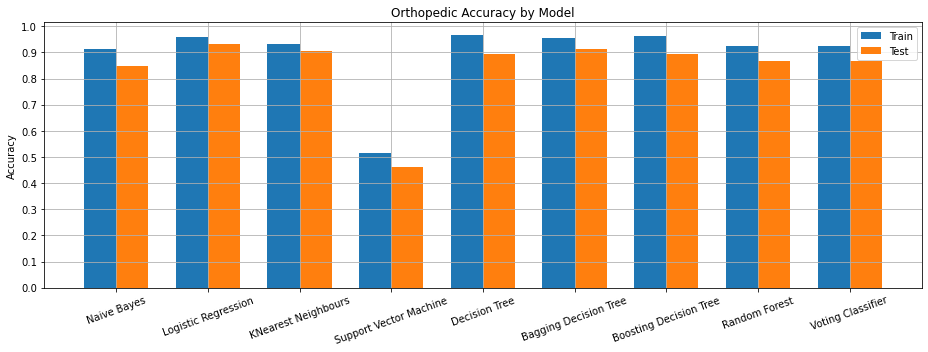

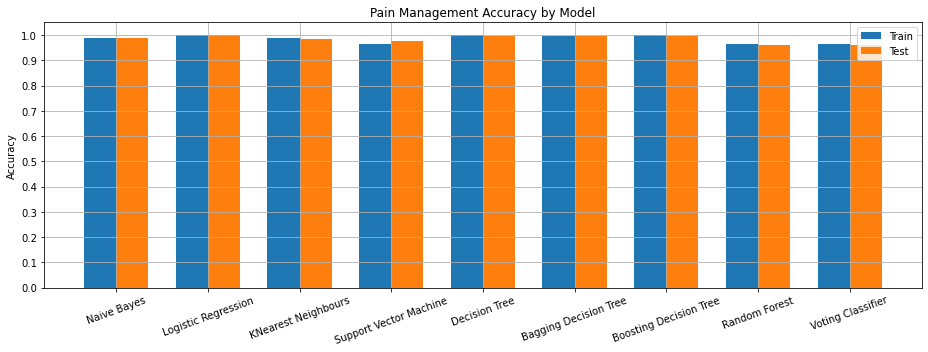

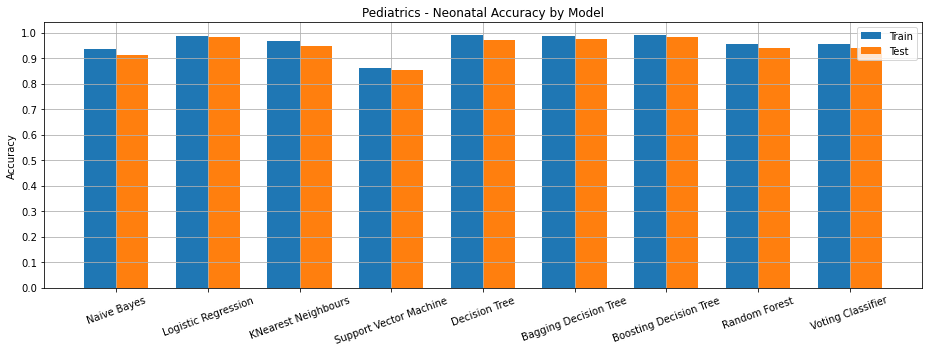

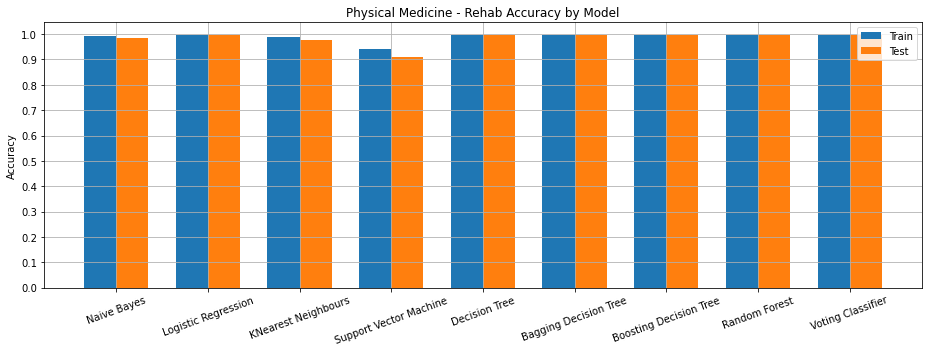

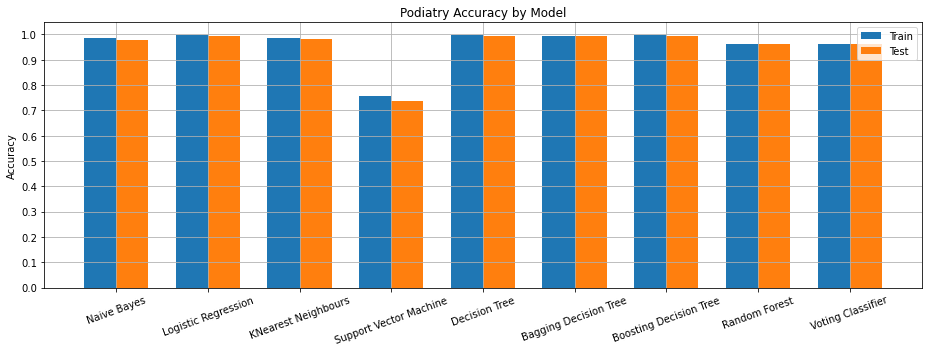

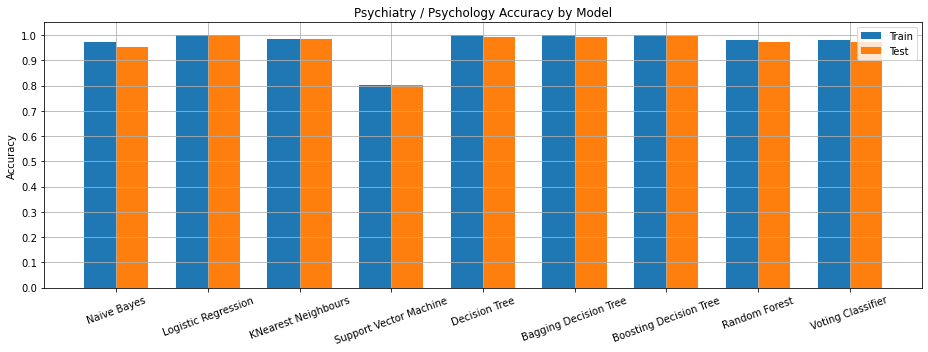

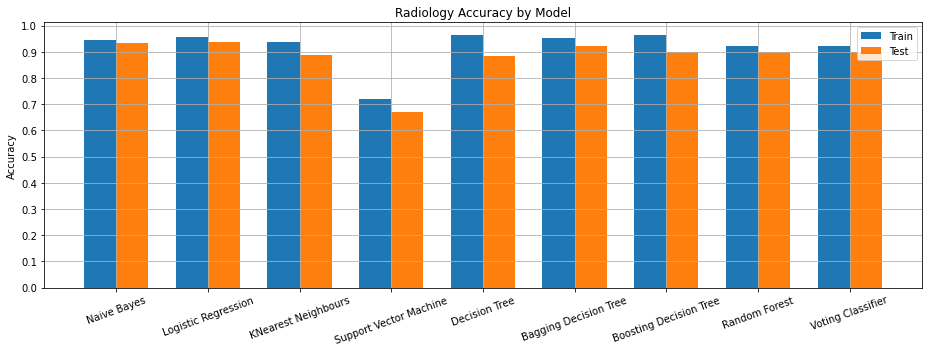

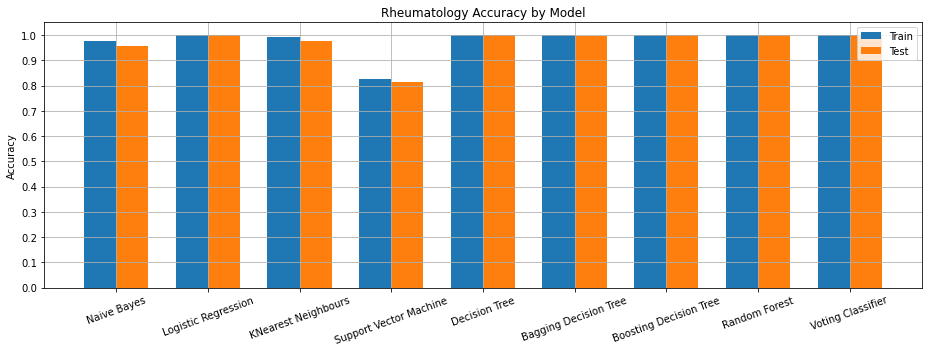

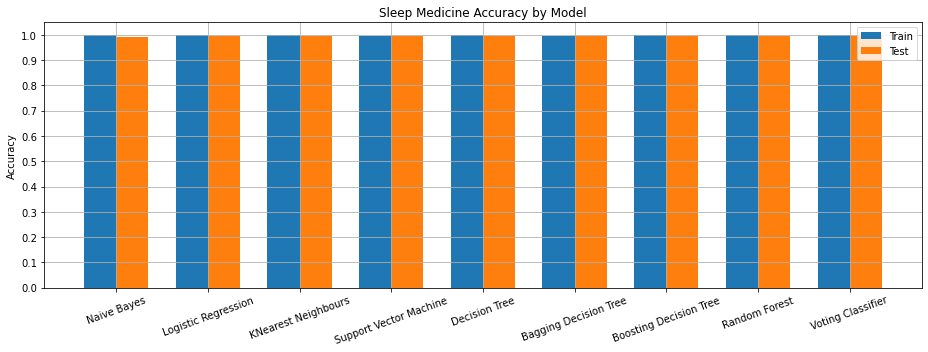

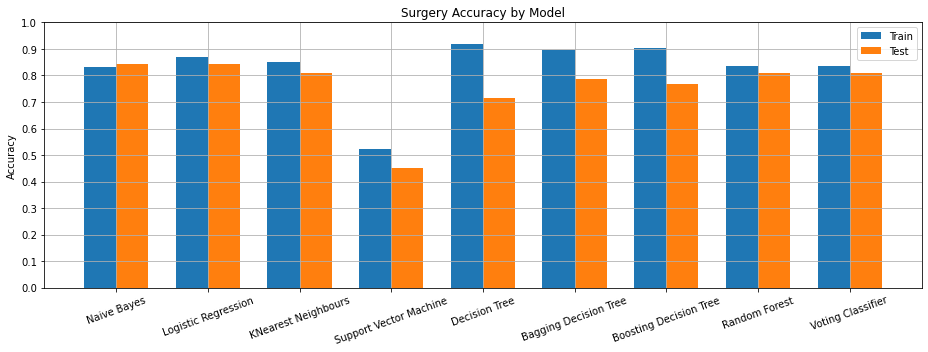

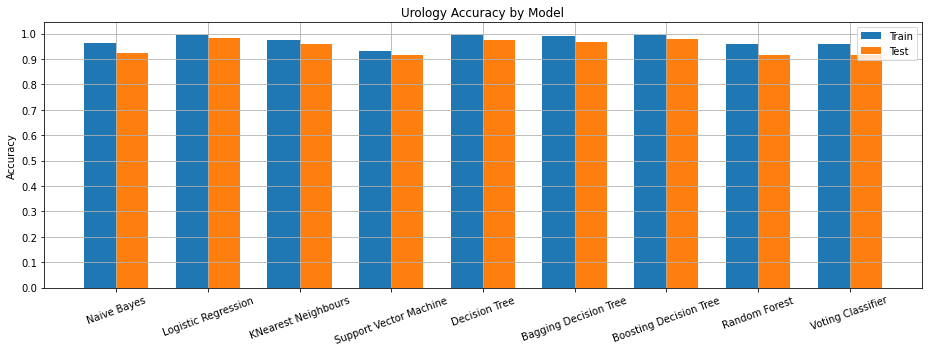

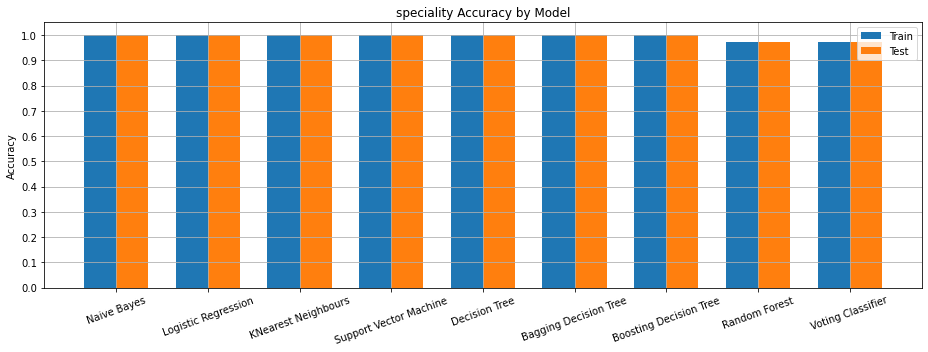

In [21]:
results = {}

for specialty in features_df.columns[-33:]:
    result = Test(features_df,specialty)
    results[specialty] = result
    plot_accuracy(result,specialty)

You can see pretty good results here (when for small data it is not so impressive because it does not have a large distribution to learn from - but for most categories the level of classification is good). <br/>
Now we just need to save the best model per specialty.

In [22]:
final_models = {}

for key, value in results.items():
    
    best_model = value['Naive Bayes']
    
    for model_key , model_value in value.items():
        # The reason I rejected a model with a perfect result is because of the fear of overfitting
        if model_value['Test Score'] !=1.0 and model_value['Test Score'] >  best_model['Test Score']:
            best_model = model_value
            
    final_models[key] = best_model
    
for key, value in final_models.items():
    key = key.replace(" / ","_")
    key = key.replace(" - ","_")
    key = key.replace(" ","_")
    dump(value, 'models/' + key + '.joblib')

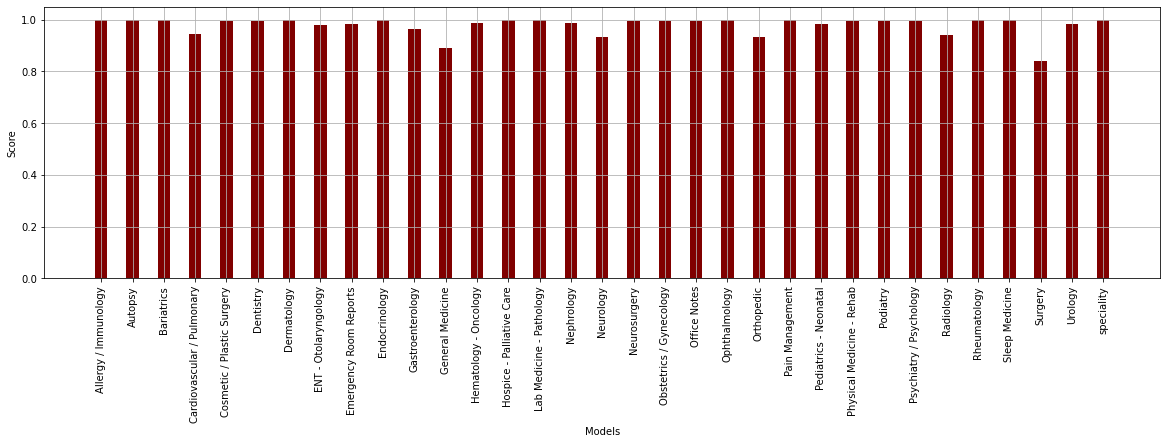

In [23]:
fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.bar(final_models.keys(),
        list(map(lambda x: x['Test Score'] ,final_models.values())),
        color ='maroon',
        width = 0.4)

plt.xticks(rotation=90)

plt.xlabel("Models")
plt.ylabel("Score")

plt.grid()

plt.show()

These are the best results for any specialty, all except surgery one, Which is not surprising given the great diversity of the data, therefore you should try a stronger model.
<br/>

*After reviewing the models on new data (in the script on the competition website) we got it in the 93% area (apart from the  surgery one)  - which means the modules do not suffer from overfitting or anything like that.*<br/><br/>
<img src="https://debuzzer.com/media/2016/02/432214_600.png" alt="drawing" width="150"/><br/>

## Deep Learning

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
       
        self.fc1 = nn.Linear(21449, 21449)  
        self.fc2 = nn.Linear(21449, 1)
        

    def forward(self, x):
       
        x = F.relu(self.fc1(x))
        x = nn.Sigmoid()(self.fc2(x))
        
        return x

In [25]:
Model = Net()

In [26]:
size = features_df[features_df['Surgery'] == 1].count()[0]
newdf = pd.concat([features_df[features_df['Surgery'] == 1] , features_df[features_df['Surgery'] != 1].sample(size)])
newdf = newdf.sample(frac=1)
X ,y = newdf.iloc[:,0:21449], newdf.iloc[:,21449:]['Surgery']
   
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

x_train, x_test, y_train, y_test = torch.tensor(x_train.to_numpy()), torch.tensor(x_test.to_numpy()), torch.tensor(y_train.to_numpy()), torch.tensor(y_test.to_numpy())

In [27]:
trainset = TensorDataset(x_train,y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
testset = TensorDataset(x_test,y_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

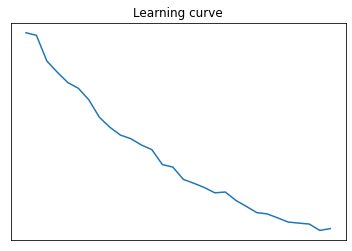

In [28]:
criterion = criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.SGD(Model.parameters(), lr=0.01, momentum=0.9)

total_loss = []

for epoch in range(30):
    
    epoch_lost = 0.0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        labels = labels.float()
        
        outputs = Model(inputs.float()).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_lost += loss.item()
        
    epoch_lost /= trainset.__len__()    
    total_loss.append(epoch_lost)
    
plt.title("Learning curve")
plt.xticks([])
plt.yticks([])
plt.plot(total_loss)
plt.grid()
plt.show()

In [30]:
correct = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = Model(inputs.float())
        outputs[outputs >= 0.5] = 1
        outputs[outputs < 0.5] = 0
        predict = outputs
        correct += (predict == labels).sum().item()

print("Accuracy: %.2f%% \n" % (correct / testset.__len__()))

Accuracy: 85.68% 



Important to note: The hypermeters were chosen after a series of experiments, plus I unfortunately did not have time to play with the network so there may be a better solution, for now the improvement of the result is quite impressive to me. <br/><br/>
__In addition, I would add Buzzwords to ensure a sure win!__